In [2]:
# Dataset and Library Importing

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-yield-prediction-dataset/yield.csv
/kaggle/input/crop-yield-prediction-dataset/temp.csv
/kaggle/input/crop-yield-prediction-dataset/rainfall.csv
/kaggle/input/crop-yield-prediction-dataset/pesticides.csv
/kaggle/input/crop-yield-prediction-dataset/yield_df.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer,
    OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelEncoder,
    PowerTransformer, QuantileTransformer,MaxAbsScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")



sns.set_style('whitegrid')
sns.set_palette(sns.color_palette(['#ADD8E6', '#FFA07A']))
plt.figure(figsize=(10, 6))
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier  # Example model


<Figure size 1000x600 with 0 Axes>

### Pesticide Dataset

Pesticides used for each item and country was also collected from FAO database.

Pesticides (tonnes) refers to the total weight of pesticides applied to crops or used in a given area, measured in metric tonnes.

Pesticides: These are chemicals used to prevent, destroy, or control pests (including insects, weeds, fungi, etc.) in agricultural fields. Tonnes: A metric tonne is equal to 1,000 kilograms (approximately 2,204.62 pounds).

In [5]:
df_pes = pd.read_csv('../input/crop-yield-prediction-dataset/pesticides.csv')
df_pes.head()

,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [6]:
df_pes = df_pes.rename(index=str, columns={"Value": "pesticides_tonnes"})
df_pes = df_pes.drop(['Element','Domain','Unit','Item'], axis=1)
df_pes.head()

,Area,Year,pesticides_tonnes
0,Albania,1990,121.0
1,Albania,1991,121.0
2,Albania,1992,121.0
3,Albania,1993,121.0
4,Albania,1994,201.0


In [7]:
df_pes.tail()

,Area,Year,pesticides_tonnes
4344,Zimbabwe,2012,3375.53
4345,Zimbabwe,2013,2550.07
4346,Zimbabwe,2014,2185.07
4347,Zimbabwe,2015,2185.07
4348,Zimbabwe,2016,2185.07


In [8]:
df_pes.shape

(4349, 3)

In [9]:
df_pes.describe()


,Year,pesticides_tonnes
count,4349.000000,4.349000e+03
mean,2003.138883,2.030334e+04
std,7.728044,1.177362e+05
min,1990.000000,0.000000e+00
25%,1996.000000,9.300000e+01
50%,2003.000000,1.137560e+03
75%,2010.000000,7.869000e+03
max,2016.000000,1.807000e+06


In [10]:
df_pes.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4349 entries, 0 to 4348
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               4349 non-null   object 
 1   Year               4349 non-null   int64  
 2   pesticides_tonnes  4349 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 135.9+ KB


### Rain Fall Dataset

In [11]:
df_rain = pd.read_csv('../input/crop-yield-prediction-dataset/rainfall.csv')
df_rain.head()


,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


In [12]:
df_rain = df_rain.rename(index=str, columns={" Area": 'Area'})


In [13]:
df_rain.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Area                           6727 non-null   object
 1   Year                           6727 non-null   int64 
 2   average_rain_fall_mm_per_year  5953 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.2+ KB


In [14]:
# convert average_rain_fall_mm_per_year from object to float
df_rain['average_rain_fall_mm_per_year'] = pd.to_numeric(df_rain['average_rain_fall_mm_per_year'],errors = 'coerce')
df_rain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           6727 non-null   object 
 1   Year                           6727 non-null   int64  
 2   average_rain_fall_mm_per_year  5947 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 210.2+ KB


In [15]:
df_rain = df_rain.dropna()


In [16]:
df_rain.tail()

,Area,Year,average_rain_fall_mm_per_year
6722,Zimbabwe,2013,657.0
6723,Zimbabwe,2014,657.0
6724,Zimbabwe,2015,657.0
6725,Zimbabwe,2016,657.0
6726,Zimbabwe,2017,657.0


In [17]:
df_rain.shape

(5947, 3)

In [18]:
df_rain.describe()


,Year,average_rain_fall_mm_per_year
count,5947.000000,5947.000000
mean,2001.365899,1124.743232
std,9.526335,786.257365
min,1985.000000,51.000000
25%,1993.000000,534.000000
50%,2001.000000,1010.000000
75%,2010.000000,1651.000000
max,2017.000000,3240.000000


### Average Temprature Dataset

Average Temprature:
Average Temprature for each country was colleced from World Bank Data


In [19]:
avg_temp=  pd.read_csv('../input/crop-yield-prediction-dataset/temp.csv')

In [20]:
avg_temp.tail()

,year,country,avg_temp
71306,2009,Mexico,21.76
71307,2010,Mexico,20.90
71308,2011,Mexico,21.55
71309,2012,Mexico,21.52
71310,2013,Mexico,22.19


In [21]:
avg_temp.shape

(71311, 3)

In [22]:
avg_temp.describe()


,year,avg_temp
count,71311.000000,68764.000000
mean,1905.799007,16.183876
std,67.102099,7.592960
min,1743.000000,-14.350000
25%,1858.000000,9.750000
50%,1910.000000,16.140000
75%,1962.000000,23.762500
max,2013.000000,30.730000


In [23]:
avg_temp = avg_temp.rename(index=str, columns={"year": "Year", "country":'Area'})
avg_temp.head()

,Year,Area,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


### Yield Dataset

In [24]:
yield_df = pd.read_csv('/kaggle/input/crop-yield-prediction-dataset/yield.csv')
yield_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


In [25]:
yield_df.shape

(56717, 12)

In [26]:
yield_df = yield_df.rename(index=str, columns={"Value": "hg/ha_yield"})
yield_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,hg/ha_yield
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


Looking at the columns in the csv, we can rename Value to hg/ha_yield to make it easier to recognise that this is our crops yields production value. In addition to removal of unnecessary coloumns like Area Code, Domain, Item Code, etc.

In [27]:
yield_df = yield_df.drop(['Year Code','Element Code','Element','Year Code','Area Code','Domain Code','Domain','Unit','Item Code'], axis=1)
yield_df.head()

,Area,Item,Year,hg/ha_yield
0,Afghanistan,Maize,1961,14000
1,Afghanistan,Maize,1962,14000
2,Afghanistan,Maize,1963,14260
3,Afghanistan,Maize,1964,14257
4,Afghanistan,Maize,1965,14400


In [28]:
yield_df = pd.merge(yield_df, df_rain, on=['Year','Area'])
yield_df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year
0,Afghanistan,Maize,1985,16652,327.0
1,Afghanistan,Maize,1986,16875,327.0
2,Afghanistan,Maize,1987,17020,327.0
3,Afghanistan,Maize,1989,16963,327.0
4,Afghanistan,Maize,1990,17582,327.0


In [29]:
yield_df.shape

(25385, 5)

In [30]:
yield_df.describe()


,Year,hg/ha_yield,average_rain_fall_mm_per_year
count,25385.000000,25385.000000,25385.000000
mean,2001.278787,68312.278353,1254.849754
std,9.143915,75213.292733,804.449430
min,1985.000000,50.000000,51.000000
25%,1994.000000,17432.000000,630.000000
50%,2001.000000,38750.000000,1150.000000
75%,2009.000000,94286.000000,1761.000000
max,2016.000000,554855.000000,3240.000000


In [31]:
yield_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25385 entries, 0 to 25384
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           25385 non-null  object 
 1   Item                           25385 non-null  object 
 2   Year                           25385 non-null  int64  
 3   hg/ha_yield                    25385 non-null  int64  
 4   average_rain_fall_mm_per_year  25385 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 991.7+ KB


### Final Dataset To be use for modeling

In [32]:
final_df = pd.read_csv('/kaggle/input/crop-yield-prediction-dataset/yield_df.csv')
final_df.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [33]:
final_df=final_df.drop('Unnamed: 0', axis=True)


In [34]:
final_df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


# Data Exploration

In [35]:
final_df.groupby('Item').count()

,Area,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
Item,,,,,,
Cassava,2045,2045,2045,2045,2045,2045
Maize,4121,4121,4121,4121,4121,4121
Plantains and others,556,556,556,556,556,556
Potatoes,4276,4276,4276,4276,4276,4276
"Rice, paddy",3388,3388,3388,3388,3388,3388
Sorghum,3039,3039,3039,3039,3039,3039
Soybeans,3223,3223,3223,3223,3223,3223
Sweet potatoes,2890,2890,2890,2890,2890,2890
Wheat,3857,3857,3857,3857,3857,3857


In [36]:
final_df.describe()


,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


In [37]:
final_df['Area'].nunique()

101

In [38]:
final_df.groupby(['Area'],sort=True)['hg/ha_yield'].sum().nlargest(10)

Area
India             327420324
Brazil            167550306
Mexico            130788528
Japan             124470912
Australia         109111062
Pakistan           73897434
Indonesia          69193506
United Kingdom     55419990
Turkey             52263950
Spain              46773540
Name: hg/ha_yield, dtype: int64

In [39]:
final_df.groupby(['Item','Area'],sort=True)['hg/ha_yield'].sum().nlargest(10)

Item            Area          
Cassava         India             142810624
Potatoes        India              92122514
                Brazil             49602168
                United Kingdom     46705145
                Australia          45670386
Sweet potatoes  India              44439538
Potatoes        Japan              42918726
                Mexico             42053880
Sweet potatoes  Mexico             35808592
                Australia          35550294
Name: hg/ha_yield, dtype: int64

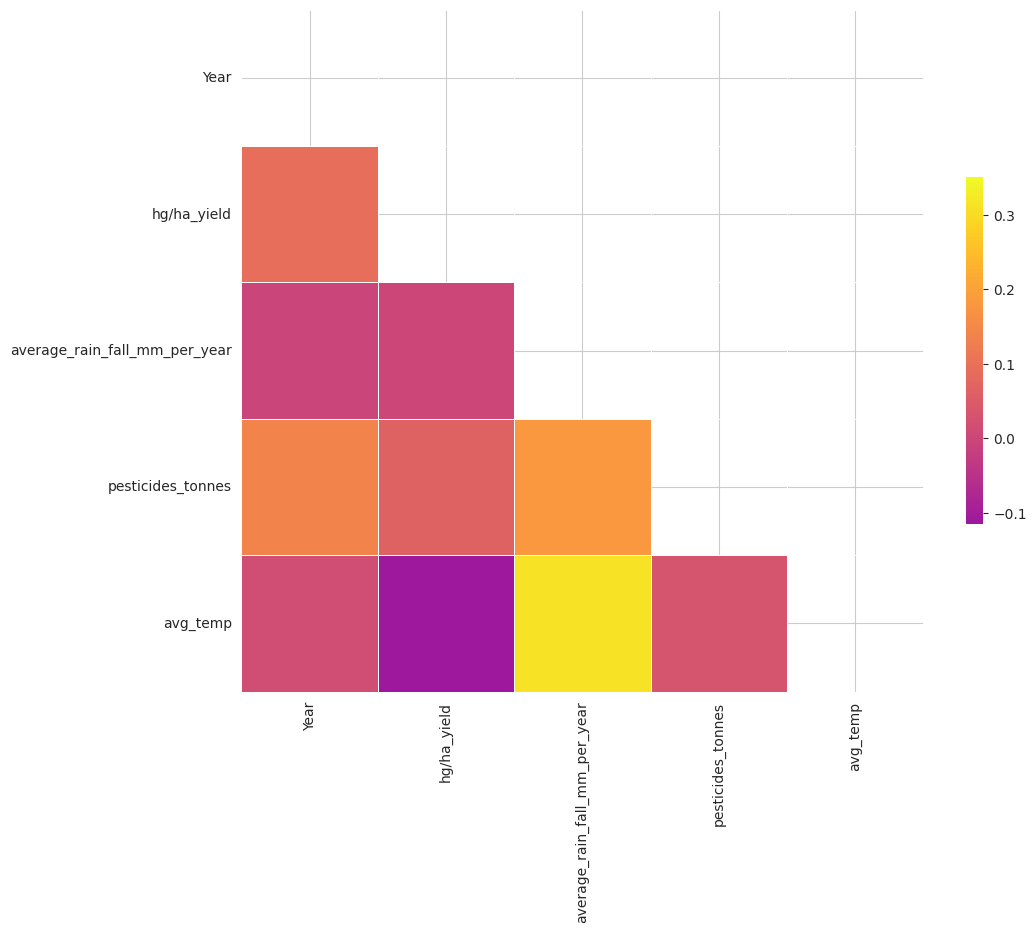

In [40]:
correlation_data=final_df.select_dtypes(include=[np.number]).corr()

mask = np.zeros_like(correlation_data, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.palette="plasma"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_data, mask=mask, cmap=cmap, vmax=.35, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [41]:
import plotly.figure_factory as ff


correlation_data = final_df.select_dtypes(include=[np.number]).corr()

# Create the labels for the heatmap
labels = correlation_data.columns.tolist()

# Mask the upper triangle for the heatmap
mask = np.triu(np.ones_like(correlation_data, dtype=bool))
masked_corr = correlation_data.where(~mask)

# Replace NaN values in the annotations with empty strings
annotation_text = masked_corr.round(2).astype(str).to_numpy()
annotation_text[np.isnan(masked_corr)] = ""

fig = ff.create_annotated_heatmap(
    z=masked_corr.to_numpy(),  # Convert the correlation matrix to numpy array
    x=labels,  # Column labels
    y=labels,  # Row labels
    colorscale='Inferno',  
    showscale=True,  
    annotation_text=annotation_text,  # Replace NaN with empty strings
    hoverinfo="none"  # Disable hover info
)

# Update the layout for better presentation
fig.update_layout(
    title='Correlation Matrix of Yield Data',
    title_x=0.5,  
    width=900,  
    height=900, 
    xaxis_showgrid=False,  
    yaxis_showgrid=False,  
    xaxis={'side': 'bottom'},  
    yaxis_autorange='reversed'  # Ensure the y-axis starts from top to bottom
)

# Show the plot
fig.show()


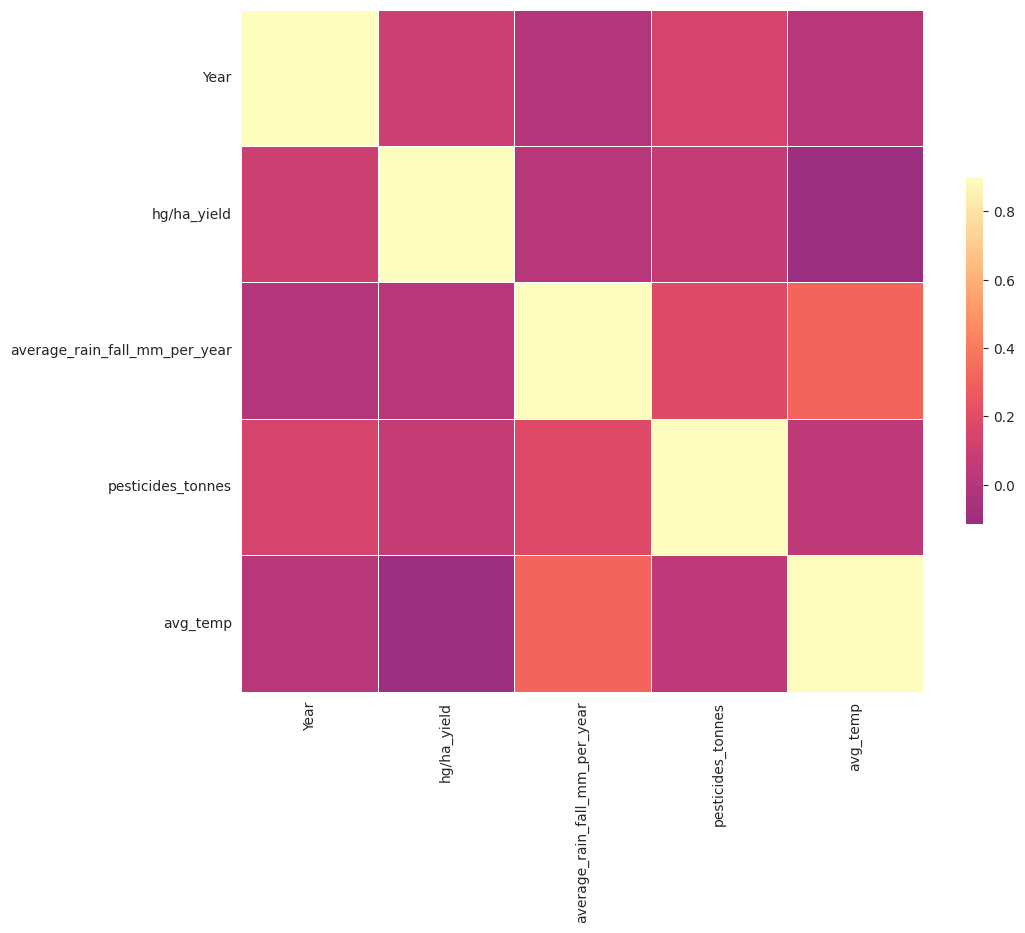

In [42]:
correlation_data=final_df.select_dtypes(include=[np.number]).corr()



f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.palette="magma"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_data, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

It can be seen from the above correlation map that there is nearly no correlation between any of the colmuns in the dataframe.

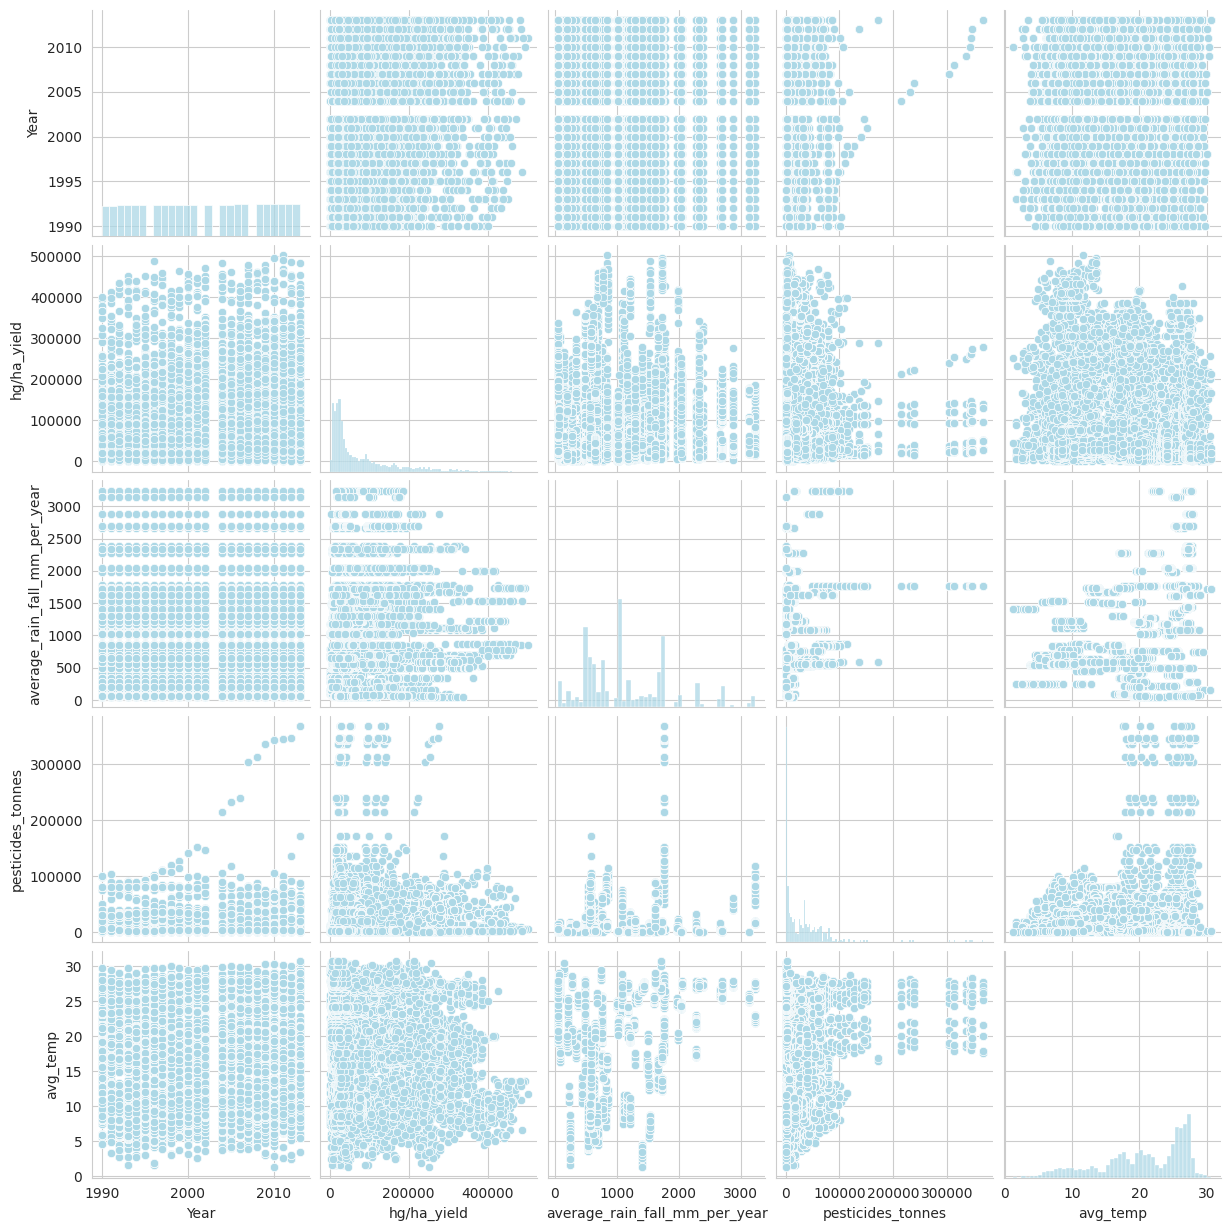

In [43]:
sns.pairplot(final_df)


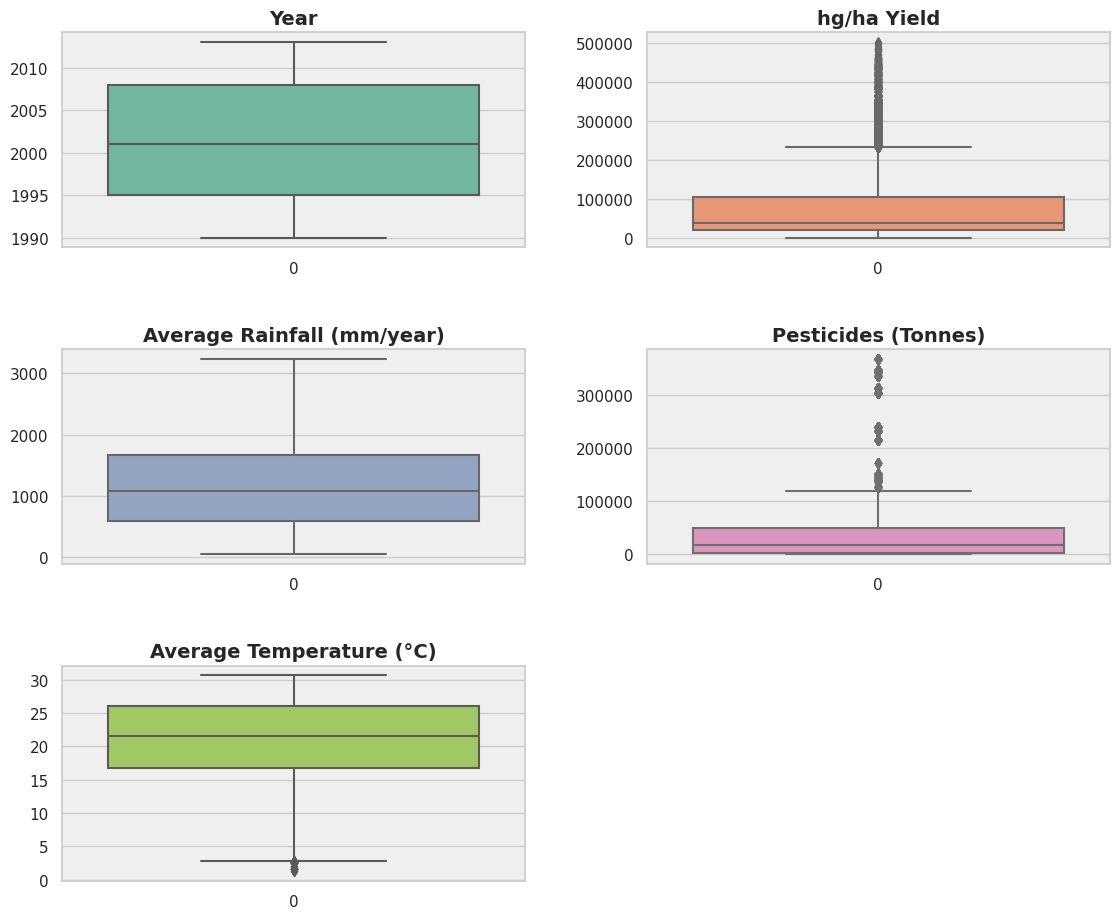

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="Set2")  # Set2 is a balanced palette for better aesthetics

# Create the figure and define the size
fig = plt.figure(figsize=(12, 10))

ax1 = plt.subplot(3, 2, 1)
sns.boxplot(data=final_df['Year'], color='#66c2a5', ax=ax1)  # Custom color for each plot
ax1.set_title('Year', fontsize=14, fontweight='bold')  # Bold title for emphasis
ax1.set_xlabel('')  # Remove x-axis label for better clarity
ax1.set_facecolor('#efefef')  # Set background color for the plot

ax2 = plt.subplot(3, 2, 2)
sns.boxplot(data=final_df['hg/ha_yield'], color='#fc8d62', ax=ax2)
ax2.set_title('hg/ha Yield', fontsize=14, fontweight='bold')
ax2.set_xlabel('')
ax2.set_facecolor('#efefef')  # Set background color for the plot

ax3 = plt.subplot(3, 2, 3)
sns.boxplot(data=final_df['average_rain_fall_mm_per_year'], color='#8da0cb', ax=ax3)
ax3.set_title('Average Rainfall (mm/year)', fontsize=14, fontweight='bold')
ax3.set_xlabel('')
ax3.set_facecolor('#efefef')  # Set background color for the plot

ax4 = plt.subplot(3, 2, 4)
sns.boxplot(data=final_df['pesticides_tonnes'], color='#e78ac3', ax=ax4)
ax4.set_title('Pesticides (Tonnes)', fontsize=14, fontweight='bold')
ax4.set_xlabel('')
ax4.set_facecolor('#efefef')  # Set background color for the plot

ax5 = plt.subplot(3, 2, 5)
sns.boxplot(data=final_df['avg_temp'], color='#a6d854', ax=ax5)
ax5.set_title('Average Temperature (°C)', fontsize=14, fontweight='bold')
ax5.set_xlabel('')
ax5.set_facecolor('#efefef')  # Set background color for the plot

plt.tight_layout(pad=3.0)

# Show the plot
plt.show()

<Axes: xlabel='Year', ylabel='Count'>

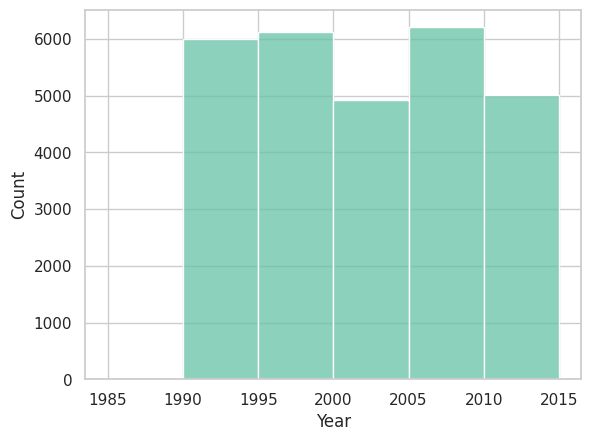

In [45]:
sns.histplot(final_df, x = 'Year' , bins = range(1985, 2020, 5))

<Figure size 1200x800 with 0 Axes>

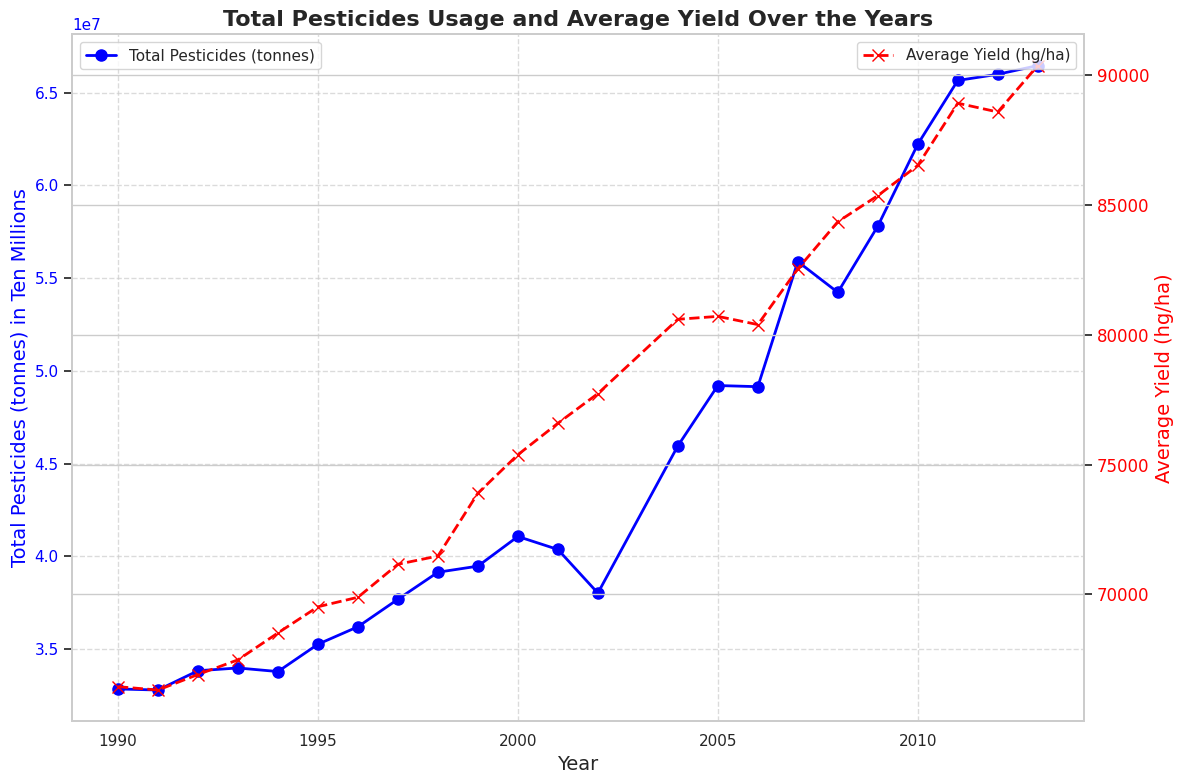

In [46]:
import matplotlib.pyplot as plt

yearly_data = final_df.groupby('Year').agg({
    'pesticides_tonnes': 'sum',
    'hg/ha_yield': 'mean'  
}).reset_index()

plt.figure(figsize=(12, 8))

fig, ax1 = plt.subplots(figsize=(12, 8))


ax1.plot(yearly_data['Year'], yearly_data['pesticides_tonnes'], 
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8, label='Total Pesticides (tonnes)')
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Total Pesticides (tonnes) in Ten Millions', fontsize=14, color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(yearly_data['Year'], yearly_data['hg/ha_yield'], 
         marker='x', color='r', linestyle='--', linewidth=2, markersize=8, label='Average Yield (hg/ha)')
ax2.set_ylabel('Average Yield (hg/ha)', fontsize=14, color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Total Pesticides Usage and Average Yield Over the Years', fontsize=16, fontweight='bold')

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add grid with customized styling
ax1.grid(True, linestyle='--', alpha=0.7)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add background color for the plot area
plt.gca().set_facecolor('#f5f5f5')

# Show the plot
plt.tight_layout()
plt.show()

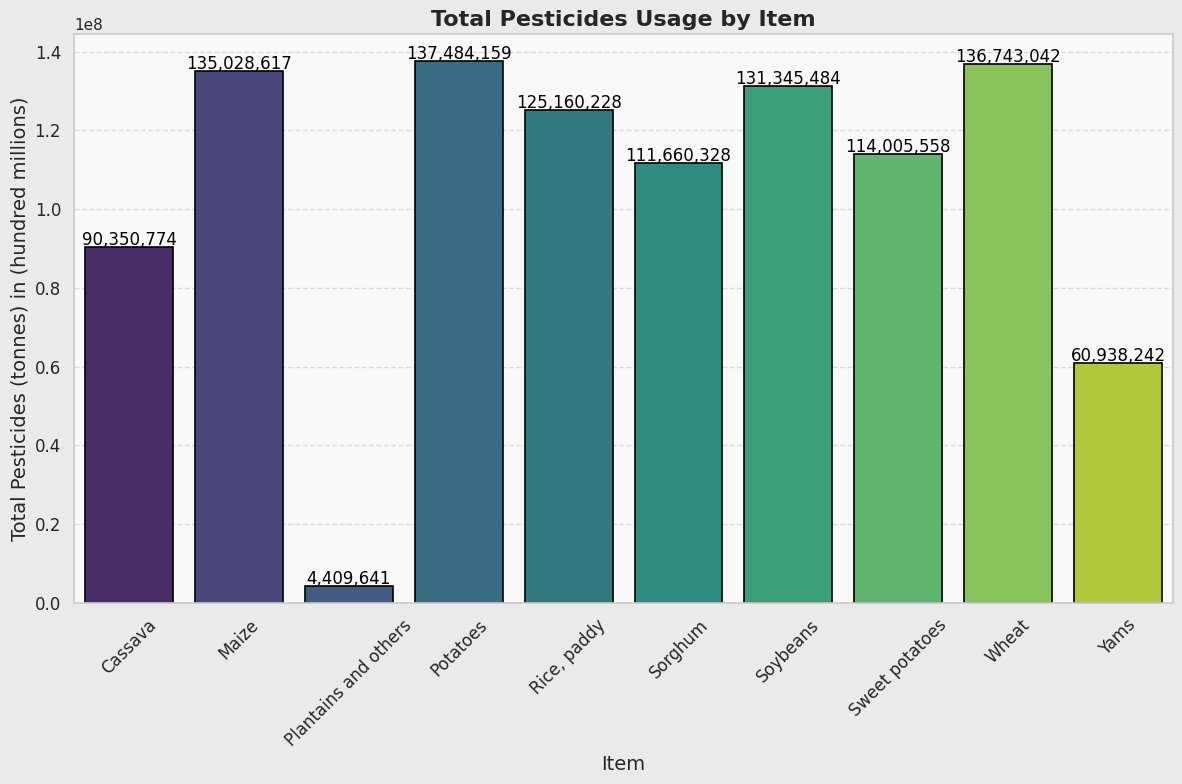

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by item and sum the pesticides_tonnes
item_pesticides = final_df.groupby('Item')['pesticides_tonnes'].sum().reset_index()

# Create the figure and define the size
plt.figure(figsize=(12, 8))

# Create a bar plot
ax = sns.barplot(x='Item', y='pesticides_tonnes', data=item_pesticides, palette='viridis')

# Add titles and labels with improved styling
plt.title('Total Pesticides Usage by Item', fontsize=16, fontweight='bold')
plt.xlabel('Item', fontsize=14)
plt.ylabel('Total Pesticides (tonnes) in (hundred millions)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Customize the bar edges
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1.2)

# Set the background color for the plot area and figure
plt.gca().set_facecolor('#f9f9f9')
plt.gcf().patch.set_facecolor('#eaeaea')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


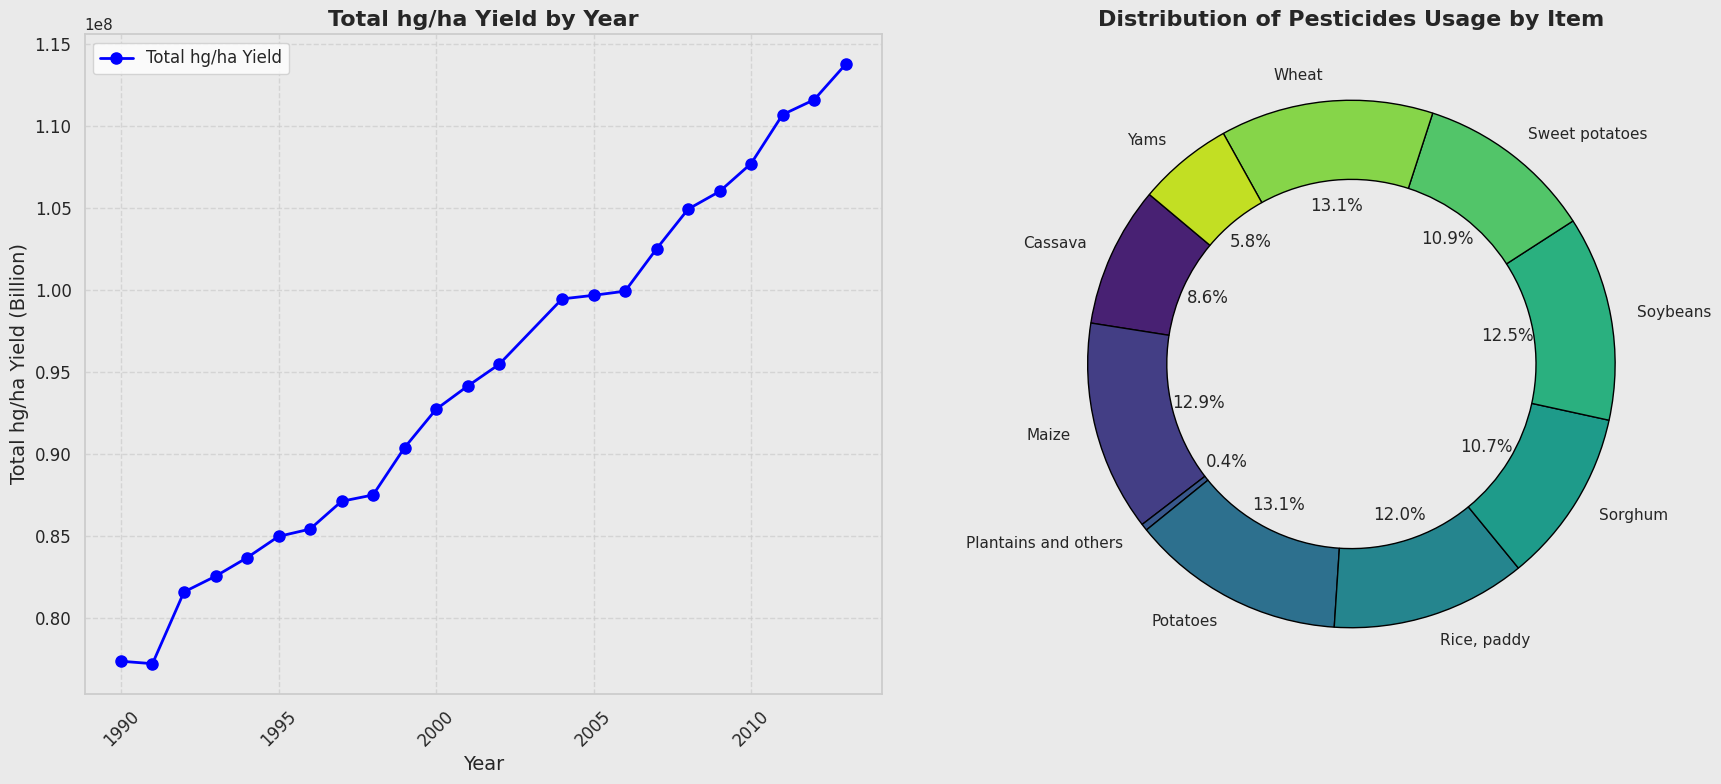

In [48]:
yearly_yield = final_df.groupby('Year')['hg/ha_yield'].sum().reset_index()

item_pesticides = final_df.groupby('Item')['pesticides_tonnes'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.plot(yearly_yield['Year'], yearly_yield['hg/ha_yield'], 
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8, label='Total hg/ha Yield')

ax1.set_title('Total hg/ha Yield by Year', fontsize=16, fontweight='bold')
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Total hg/ha Yield (Billion)', fontsize=14)

# Rotate x-axis labels for better readability
ax1.tick_params(axis='x', rotation=45, labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

# Add grid with customized styling
ax1.grid(True, linestyle='--', alpha=0.7)

ax1.legend(fontsize=12, loc='upper left')

ax1.set_facecolor('#eaeaea')  
fig.patch.set_facecolor('#eaeaea') 

ax2.pie(item_pesticides['pesticides_tonnes'], 
        labels=item_pesticides['Item'], 
        autopct='%1.1f%%', 
        colors=sns.color_palette('viridis', len(item_pesticides)),
        wedgeprops=dict(width=0.3, edgecolor='black'),  # Create the donut effect
        startangle=140)

ax2.set_title('Distribution of Pesticides Usage by Item', fontsize=16, fontweight='bold')

ax2.set_facecolor('#eaeaea')  

plt.tight_layout()

# Show the plots
plt.show()


In [49]:
temp_mean = final_df['avg_temp'].mean()
final_df['yield_per_pesticide'] = final_df['hg/ha_yield'] / final_df['pesticides_tonnes']
final_df['yield_per_rainfall'] = final_df['hg/ha_yield'] / final_df['average_rain_fall_mm_per_year']
final_df['temp_deviation'] = final_df['avg_temp'] - temp_mean

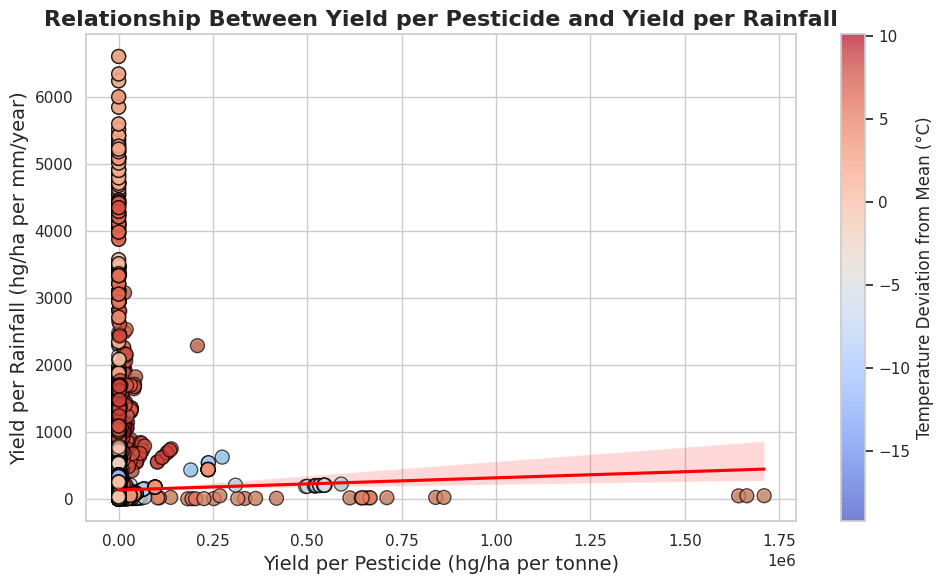

In [50]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a scatter plot with a regression line
sns.regplot(x='yield_per_pesticide', y='yield_per_rainfall', data=final_df, scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Color the points based on temperature deviation
points = plt.scatter(final_df['yield_per_pesticide'], final_df['yield_per_rainfall'], 
                     c=final_df['temp_deviation'], cmap='coolwarm', s=100, edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Relationship Between Yield per Pesticide and Yield per Rainfall', fontsize=16, fontweight='bold')
plt.xlabel('Yield per Pesticide (hg/ha per tonne)', fontsize=14)
plt.ylabel('Yield per Rainfall (hg/ha per mm/year)', fontsize=14)

# Add a color bar to indicate the temperature deviation
cbar = plt.colorbar(points)
cbar.set_label('Temperature Deviation from Mean (°C)', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


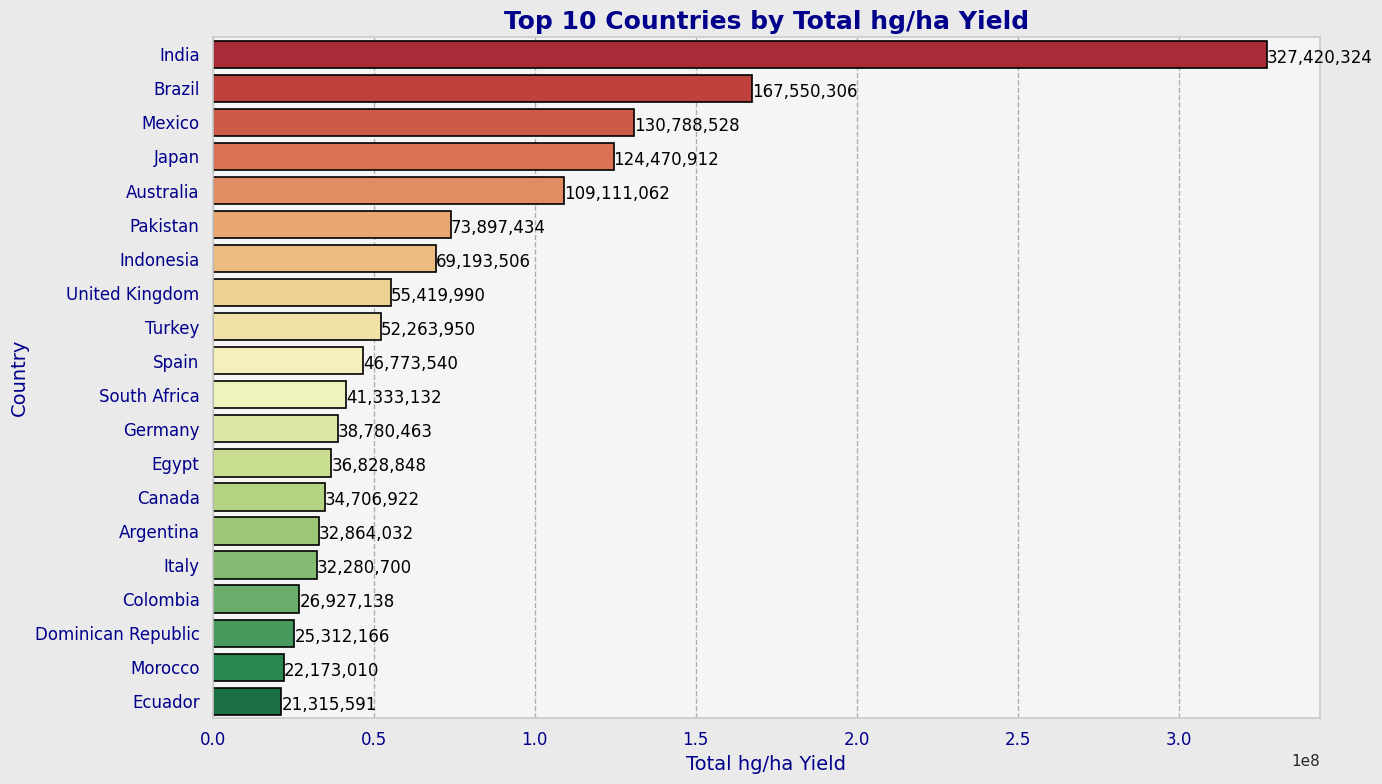

In [51]:
country_yield = final_df.groupby('Area')['hg/ha_yield'].sum().reset_index()

# Sort the countries by yield in descending order and select the top 10
top_countries_yield = country_yield.sort_values(by='hg/ha_yield', ascending=False).head(20)

# Create the figure and define the size
plt.figure(figsize=(14, 8))

# Create a bar plot for the top 10 countries with enhanced design
ax = sns.barplot(x='hg/ha_yield', y='Area', data=top_countries_yield, palette='RdYlGn', edgecolor='black')

# Add value annotations on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f}', (p.get_width() + 0.05, p.get_y() + 0.5),
                ha='left', va='center', fontsize=12, color='black')

# Add titles and labels with improved styling
plt.title('Top 10 Countries by Total hg/ha Yield', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Total hg/ha Yield', fontsize=14, color='darkblue')
plt.ylabel('Country', fontsize=14, color='darkblue')

# Rotate x-axis labels for better readability and set their size
plt.xticks(fontsize=12, color='darkblue')
plt.yticks(fontsize=12, color='darkblue')

# Add customized grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.6, color='gray')

# Customize bar edges
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1.2)

# Set the background color for the plot area and figure
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().patch.set_facecolor('#eaeaea')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


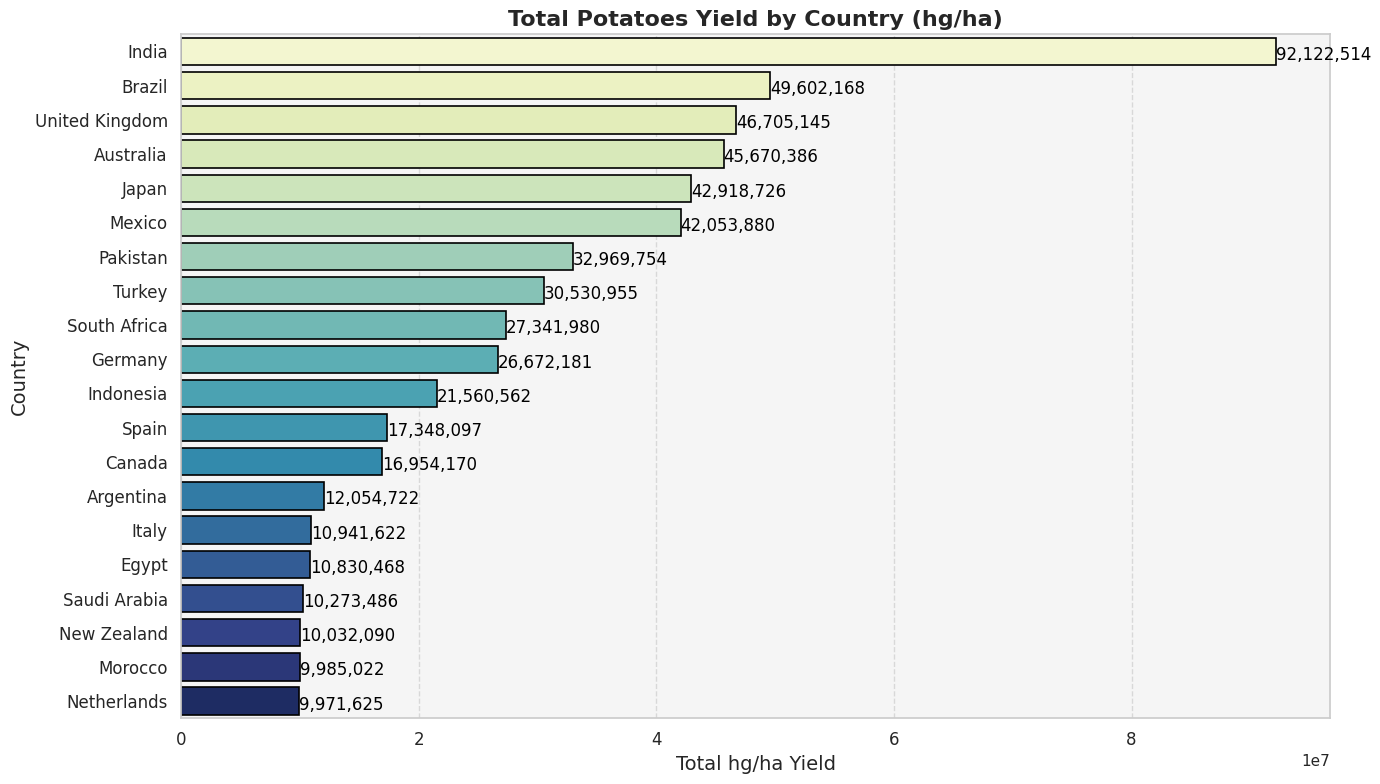

In [52]:
# Filter the dataset for 'Potatoes' only
potatoes_df = final_df[final_df['Item'] == 'Potatoes']

# Group by 'Area' and sum the 'hg/ha_yield'
potatoes_area_yield = potatoes_df.groupby('Area')['hg/ha_yield'].sum().reset_index()

# Sort by 'hg/ha_yield' in descending order
potatoes_area_yield = potatoes_area_yield.sort_values(by='hg/ha_yield', ascending=False).head(20)

# Create the figure and define the size
plt.figure(figsize=(14, 8))

# Create a bar plot for the potatoes yield by area
ax = sns.barplot(x='hg/ha_yield', y='Area', data=potatoes_area_yield, palette='YlGnBu', edgecolor='black')

# Add titles and labels
plt.title('Total Potatoes Yield by Country (hg/ha)', fontsize=16, fontweight='bold')
plt.xlabel('Total hg/ha Yield', fontsize=14)
plt.ylabel('Country', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value annotations on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f}', (p.get_width() + 0.05, p.get_y() + 0.5),
                ha='left', va='center', fontsize=12, color='black')

# Customize the bar edges
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1.2)

# Set the background color for the plot area
plt.gca().set_facecolor('#f5f5f5')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


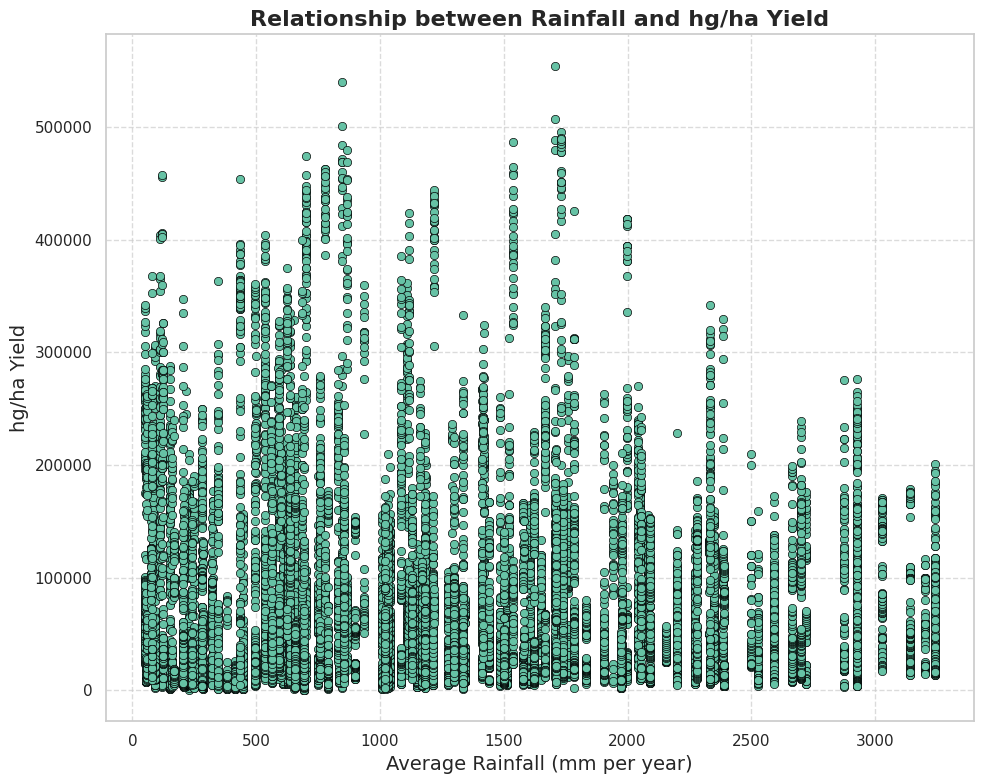

In [53]:
# Create the figure and define the size
plt.figure(figsize=(10, 8))

# Create a scatter plot to visualize the relationship between rainfall and yield
sns.scatterplot(x='average_rain_fall_mm_per_year', y='hg/ha_yield', data=yield_df, palette='coolwarm', edgecolor='black')

# Add a title and labels
plt.title('Relationship between Rainfall and hg/ha Yield', fontsize=16, fontweight='bold')
plt.xlabel('Average Rainfall (mm per year)', fontsize=14)
plt.ylabel('hg/ha Yield', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


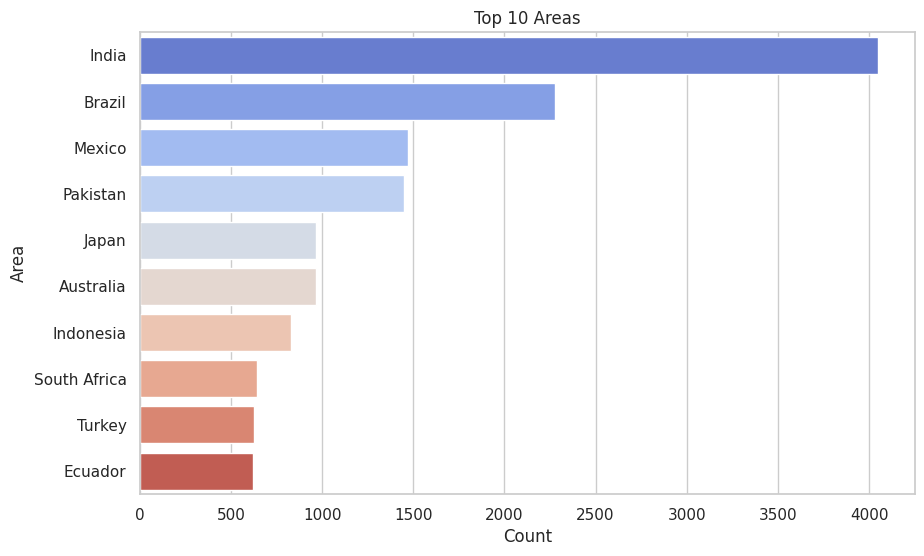

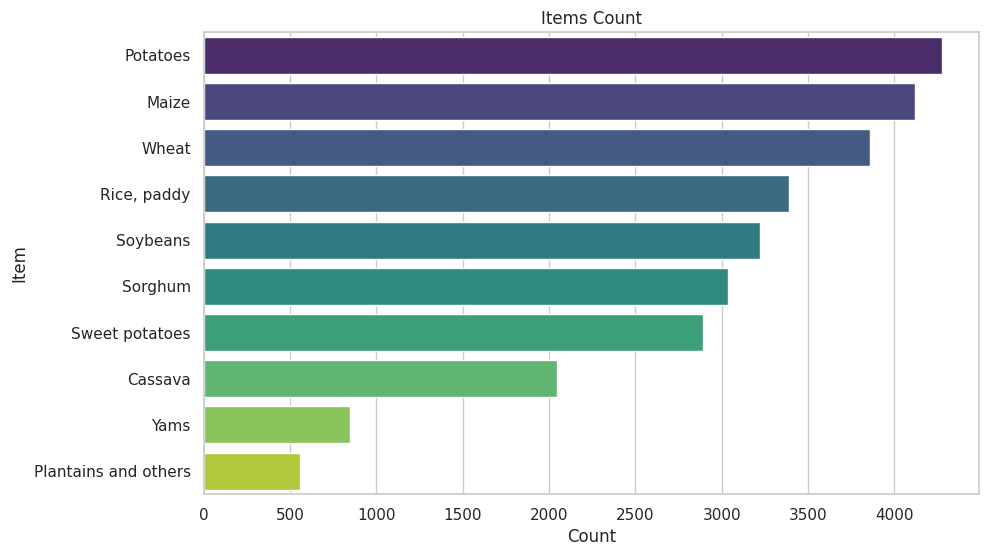

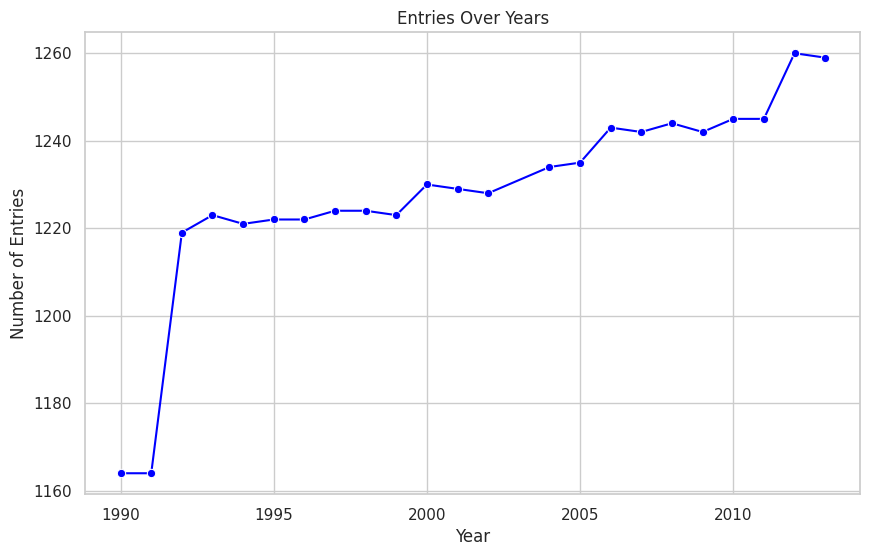

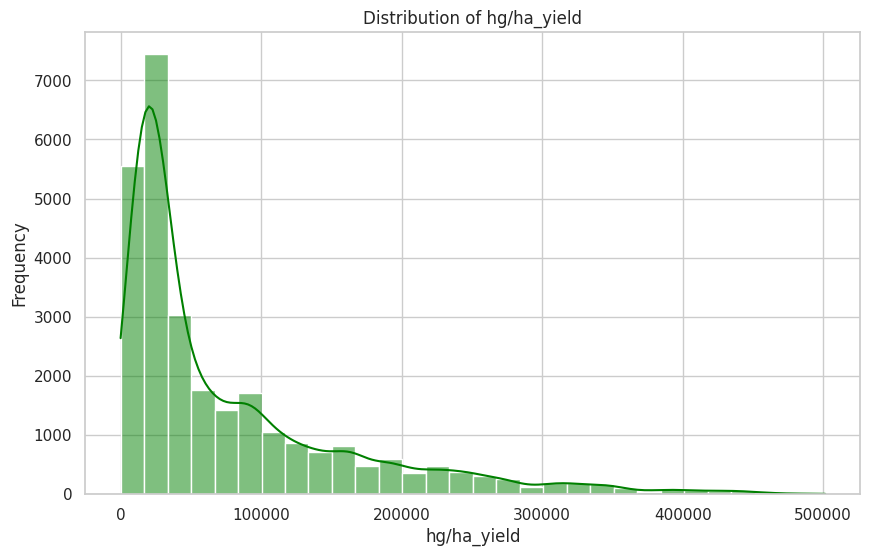

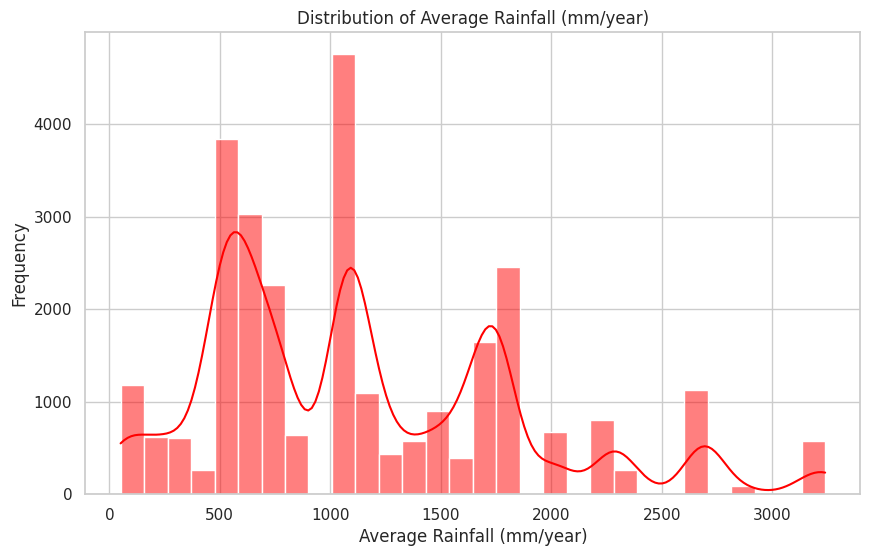

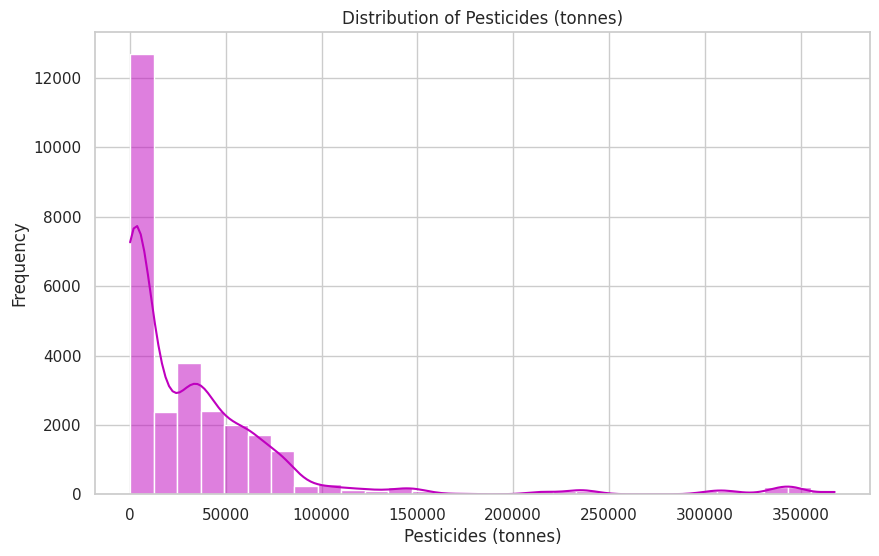

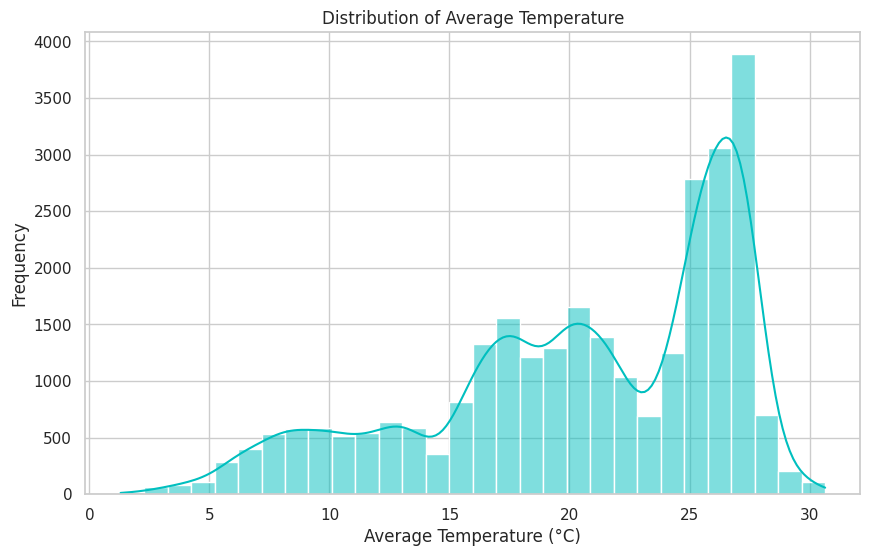

In [54]:
# Plot for each column with appropriate visualizations

import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Increase the default figure size for better readability
plt.rcParams['figure.figsize'] = [10, 6]

## Area (Bar Plot of Top 10 Areas)
plt.figure()
area_counts = final_df['Area'].value_counts().head(10)
sns.barplot(x=area_counts.values, y=area_counts.index, palette='coolwarm')
plt.title('Top 10 Areas')
plt.xlabel('Count')
plt.ylabel('Area')
plt.show()

## Item (Bar Plot of Items)
plt.figure()
item_counts = final_df['Item'].value_counts()
sns.barplot(x=item_counts.values, y=item_counts.index, palette='viridis')
plt.title('Items Count')
plt.xlabel('Count')
plt.ylabel('Item')
plt.show()

## Year (Line Plot of Entries Over Years)
plt.figure()
year_counts = final_df['Year'].value_counts().sort_index()
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o', color='b')
plt.title('Entries Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.show()

## hg/ha_yield (Histogram)
plt.figure()
sns.histplot(final_df['hg/ha_yield'], bins=30, kde=True, color='g')
plt.title('Distribution of hg/ha_yield')
plt.xlabel('hg/ha_yield')
plt.ylabel('Frequency')
plt.show()

## average_rain_fall_mm_per_year (Histogram)
plt.figure()
sns.histplot(final_df['average_rain_fall_mm_per_year'], bins=30, kde=True, color='r')
plt.title('Distribution of Average Rainfall (mm/year)')
plt.xlabel('Average Rainfall (mm/year)')
plt.ylabel('Frequency')
plt.show()

## pesticides_tonnes (Histogram)
plt.figure()
sns.histplot(final_df['pesticides_tonnes'], bins=30, kde=True, color='m')
plt.title('Distribution of Pesticides (tonnes)')
plt.xlabel('Pesticides (tonnes)')
plt.ylabel('Frequency')
plt.show()

## avg_temp (Histogram)
plt.figure()
sns.histplot(final_df['avg_temp'], bins=30, kde=True, color='c')
plt.title('Distribution of Average Temperature')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

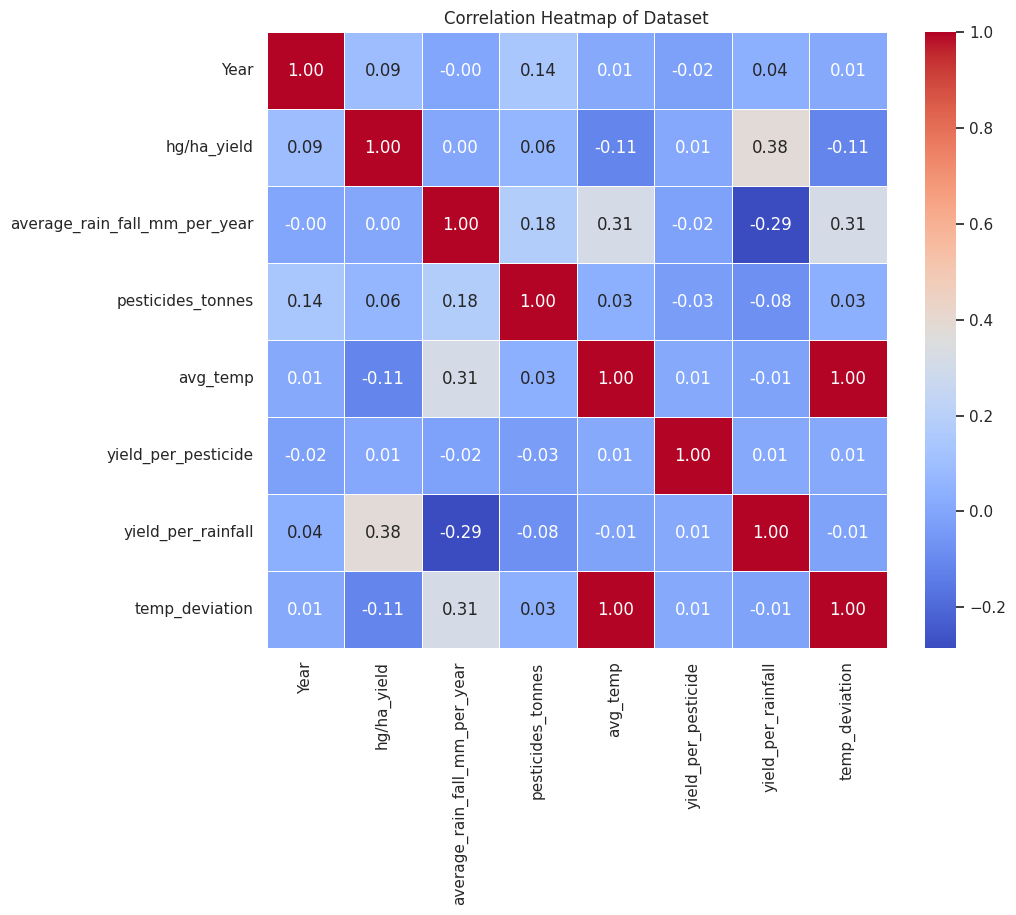

In [55]:
# Creating a correlation heatmap for the numerical columns in the dataset

# Calculate the correlation matrix
corr_matrix = final_df.corr(numeric_only=True)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Dataset')
plt.show()

In [56]:
df_pes

,Area,Year,pesticides_tonnes
0,Albania,1990,121.00
1,Albania,1991,121.00
2,Albania,1992,121.00
3,Albania,1993,121.00
4,Albania,1994,201.00
...,...,...,...
4344,Zimbabwe,2012,3375.53
4345,Zimbabwe,2013,2550.07
4346,Zimbabwe,2014,2185.07
4347,Zimbabwe,2015,2185.07


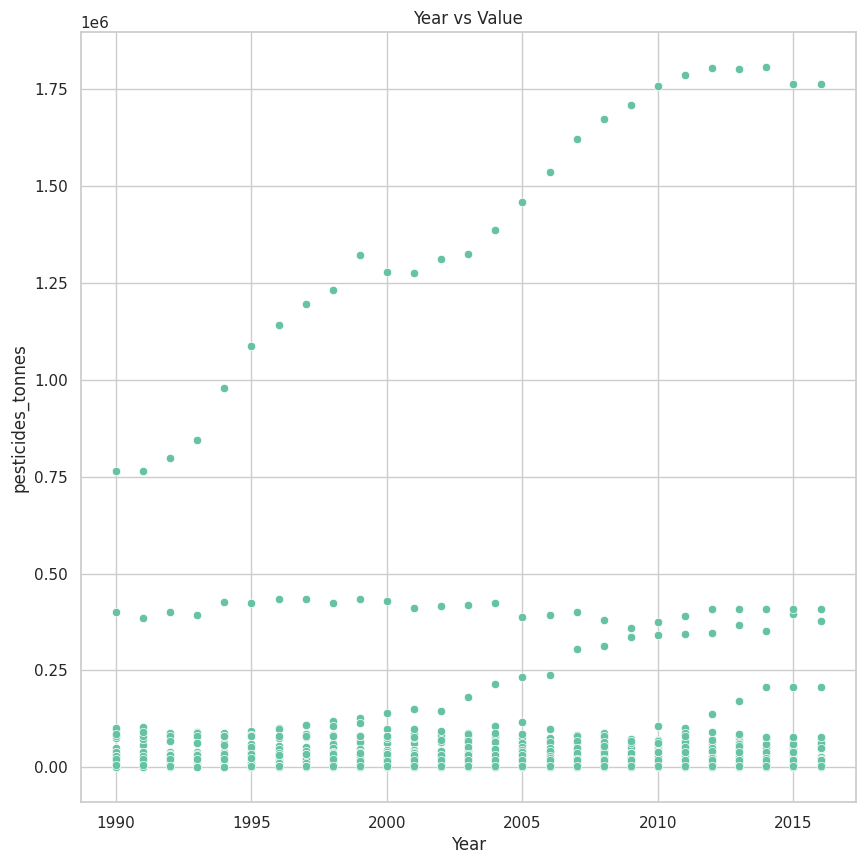

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_pes, x="Year", y="pesticides_tonnes")
plt.title("Year vs Value")
plt.grid(True)

<Axes: xlabel='Area', ylabel='Year'>

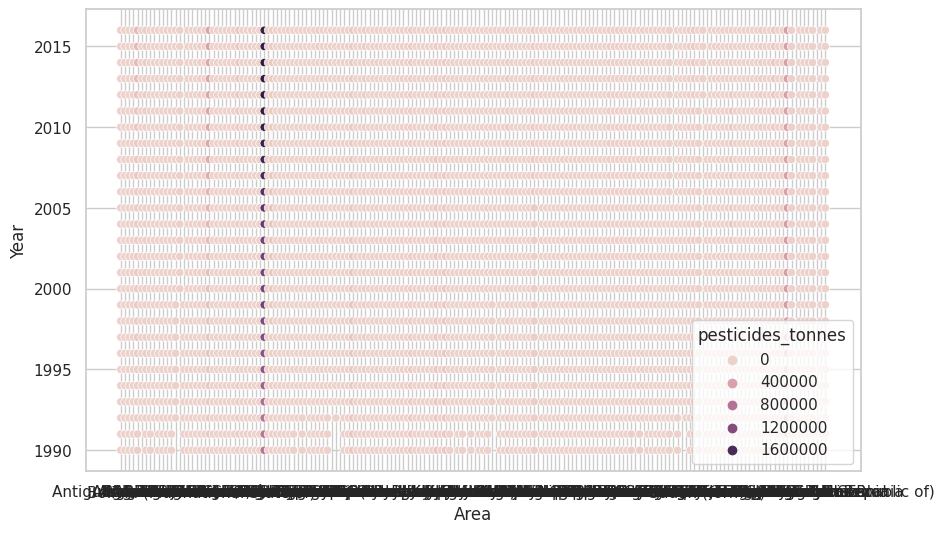

In [58]:
sns.scatterplot(data=df_pes, x="Area", y="Year", hue="pesticides_tonnes")


<Axes: xlabel='Year'>

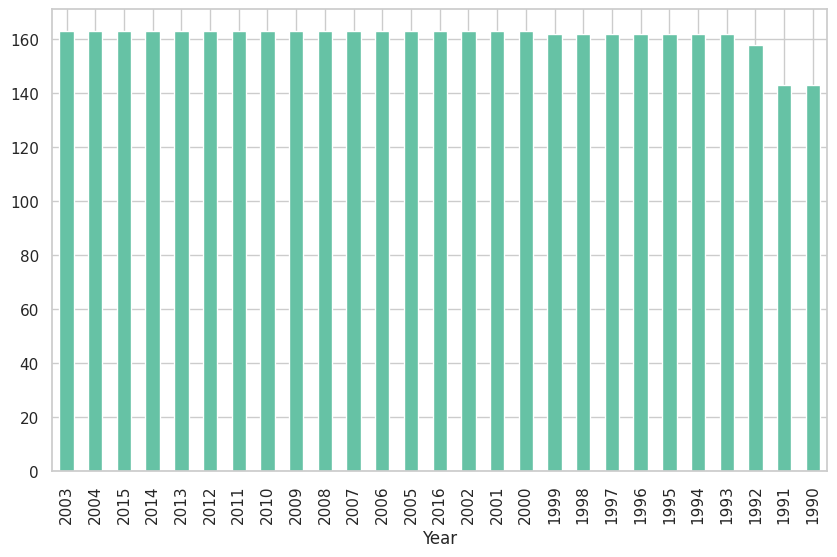

In [59]:
df_pes.Year.value_counts().plot(kind="bar")


In [60]:
dz_filter = df_pes.Area == "Algeria"

df_dz_pes = df_pes[dz_filter]

In [61]:
df_dz_pes.head()


,Area,Year,pesticides_tonnes
27,Algeria,1990,1828.92
28,Algeria,1991,2461.80
29,Algeria,1992,1215.47
30,Algeria,1993,1021.89
31,Algeria,1994,1255.02


In [62]:
df_dz_pes.Year.unique().tolist()


[1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016]

In [63]:
df_dz_2001 = df_dz_pes[df_dz_pes.Year==2001]

In [64]:
df_dz_2001.head()


,Area,Year,pesticides_tonnes
38,Algeria,2001,710.11


<Axes: ylabel='count'>

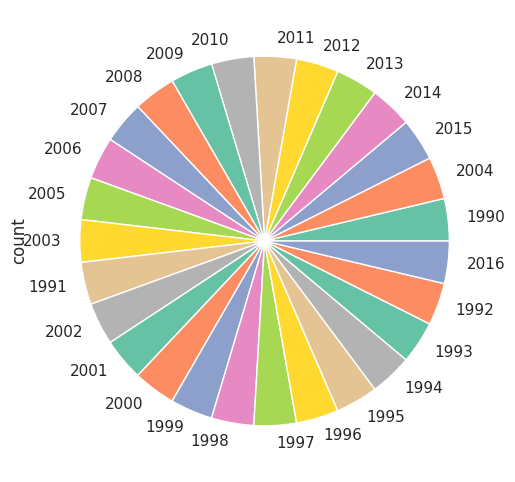

In [65]:
df_dz_pes.Year.value_counts().plot(kind="pie")


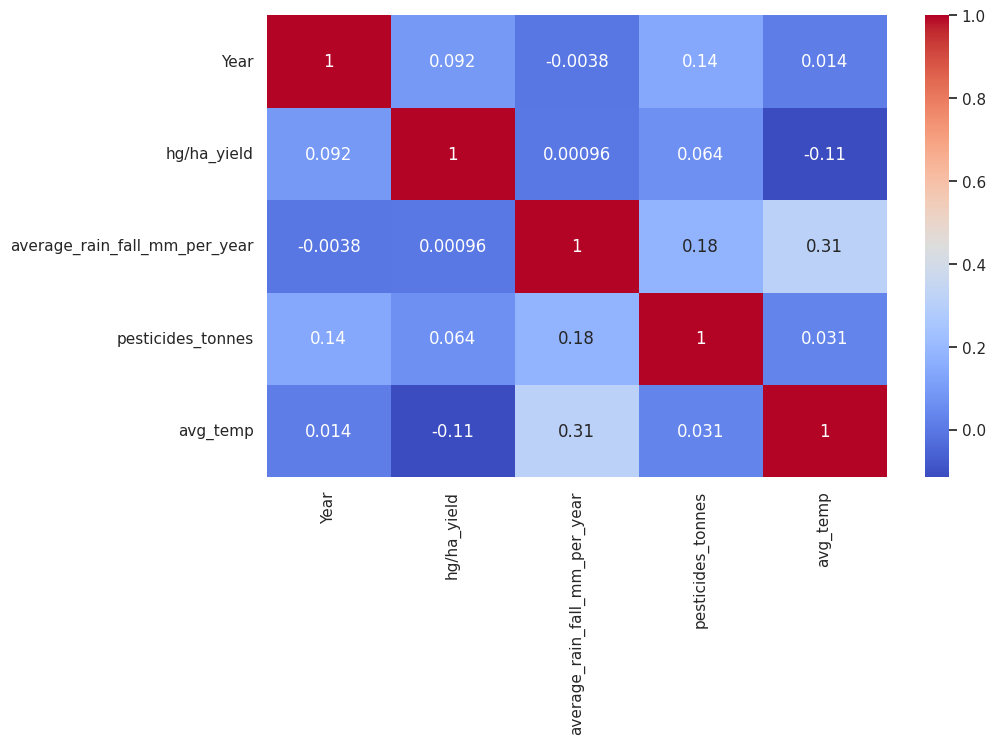

In [66]:
corr_matrix = final_df[['Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [67]:
final_df['yield_lag1'] = final_df['hg/ha_yield'].shift(1)  # 1-year lag
final_df['rainfall_lag1'] = final_df['average_rain_fall_mm_per_year'].shift(1)
final_df['pesticides_lag1'] = final_df['pesticides_tonnes'].shift(1)


In [68]:
final_df['yield_lag1']

0             NaN
1         36613.0
2         66667.0
3         23333.0
4         12500.0
           ...   
28237    165714.0
28238     22581.0
28239      3066.0
28240     13142.0
28241     22222.0
Name: yield_lag1, Length: 28242, dtype: float64

In [69]:
final_df['rainfall_lag1']

0           NaN
1        1485.0
2        1485.0
3        1485.0
4        1485.0
          ...  
28237     657.0
28238     657.0
28239     657.0
28240     657.0
28241     657.0
Name: rainfall_lag1, Length: 28242, dtype: float64

In [70]:
final_df['pesticides_lag1'] 

0            NaN
1         121.00
2         121.00
3         121.00
4         121.00
          ...   
28237    2550.07
28238    2550.07
28239    2550.07
28240    2550.07
28241    2550.07
Name: pesticides_lag1, Length: 28242, dtype: float64

In [73]:
final_df['temp_category'] = pd.cut(final_df['avg_temp'], bins=[0, 15, 25, 35], labels=['Low', 'Medium', 'High'])
final_df['temp_category'] 

0        Medium
1        Medium
2        Medium
3        Medium
4        Medium
          ...  
28237    Medium
28238    Medium
28239    Medium
28240    Medium
28241    Medium
Name: temp_category, Length: 28242, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

In [76]:
final_df['yield_temp_interaction'] = final_df['hg/ha_yield'] * final_df['avg_temp']
final_df['yield_temp_interaction']

0         599354.81
1        1091338.79
2         381961.21
3         204625.00
4         114590.00
            ...    
28237     446200.56
28238      60584.16
28239     259685.92
28240     439106.72
28241     452266.88
Name: yield_temp_interaction, Length: 28242, dtype: float64

In [78]:
final_df['rainfall_pesticide_interaction'] = final_df['average_rain_fall_mm_per_year'] * final_df['pesticides_tonnes']
final_df['rainfall_pesticide_interaction']

0         179685.00
1         179685.00
2         179685.00
3         179685.00
4         179685.00
            ...    
28237    1675395.99
28238    1675395.99
28239    1675395.99
28240    1675395.99
28241    1675395.99
Name: rainfall_pesticide_interaction, Length: 28242, dtype: float64

In [79]:
final_df['mean_yield_by_area'] = final_df.groupby('Area')['hg/ha_yield'].transform('mean')
final_df['mean_temp_by_item'] = final_df.groupby('Item')['avg_temp'].transform('mean')


In [80]:
final_df['mean_yield_by_area'] 

0        57692.282828
1        57692.282828
2        57692.282828
3        57692.282828
4        57692.282828
             ...     
28237    40264.288043
28238    40264.288043
28239    40264.288043
28240    40264.288043
28241    40264.288043
Name: mean_yield_by_area, Length: 28242, dtype: float64

In [81]:
final_df['mean_temp_by_item']

0        19.925159
1        19.007725
2        21.265378
3        21.431586
4        19.660279
           ...    
28237    21.265378
28238    21.431586
28239    19.660279
28240    22.178668
28241    18.131623
Name: mean_temp_by_item, Length: 28242, dtype: float64